In [7]:
%load_ext rpy2.ipython

# Analysis of Patent Network

Elliot Williams<br>
March 24, 2018<br>
Web Scraping w. Prof. Oleinikov

## Brief Description

For my final project, I wrote a scraper for the US Patent and Trademark Office's [Patent Database](http://patft.uspto.gov/). The website accepts searches for patents held by a particular company, and returns the results for a particular US Patent Collection search as a very poorly formatted HTML doc, which makes scraping the website particularly time consuming. The scraper itself was written in Python 3, utilizing the urllib, lxml, re, and time libraries. 


## The Scraper

The code below scrapes the links associated with all registed patents for each of the technology companies:
Apple, Facebook, Google, Snap, Uber, Twitter, IBM, Amazon, and Microsoft

In [4]:
import urllib
from lxml import html
import re
import time


def scrape_patent(url):      
    
    f = urllib.request.urlopen(url)
    raw_html = f.read()
    
    # The HTML is formatted weird on the site, which lets us
    # use regex to get only the table with patents inside
    m = re.search('<TABLE>.*</TABLE>', str(raw_html))
    table_raw_html = m.group(0)
    
    doc = html.fromstring(table_raw_html)
    
    links = doc.xpath("//a/@href")
    links = list(set(links))
    return(url, links)
    

    
def scrape_patents_from_company(company):
    # Note that we can generate any arbitrary page of results by modifying the p parameter    
    link_list = []
    p = 1
    num_error = 0
    print("Scraping patents from {}".format(company))
    while True:
        try:
            current_url = "http://patft.uspto.gov/netacgi/nph-Parser?Sect1=PTO2&Sect2=HITOFF&p={}&u=%2Fnetahtml%2FPTO%2Fsearch-bool.html&r=0&f=S&l=50&TERM1={}&FIELD1=AANM&co1=AND&TERM2=&FIELD2=&d=PTXT".format(p, company)
            curr_url, more_links = scrape_patent(current_url)
            link_list += more_links
            p += 1
            num_error = 0
            time.sleep(0.05)
        except Exception:
            num_error += 1
            time.sleep(5)
            # Assuming that the scraper can't scrape results 5 times running,
            # it's fair to say there are no more results.
            if num_error > 5:
                break
                
    return link_list

apple_patents = scrape_patents_from_company("Apple")
fb_patents = scrape_patents_from_company("Facebook")    
google_patents = scrape_patents_from_company("Google")
snap_patents = scrape_patents_from_company("Snap")
uber_patents = scrape_patents_from_company("Uber")
twitter_patents = scrape_patents_from_company("Twitter")
ibm_patents = scrape_patents_from_company("IBM")
amazon_patents = scrape_patents_from_company("Amazon")
microsoft_patents = scrape_patents_from_company("Microsoft")

Scraping patents from Apple
Scraping patents from Facebook
Scraping patents from Google
Scraping patents from Snap
Scraping patents from Uber
Scraping patents from Twitter
Scraping patents from IBM
Scraping patents from Amazon
Scraping patents from Microsoft


Now, let's format that data into a pandas dataframe (which we can then import into R and plot using ggplot)

In [5]:
import pandas as pd

company_list = ["Apple", "Facebook", "Google", "Snap", "Uber", "Twitter", "IBM", "Amazon", "Microsoft"]
num_patent_list = [apple_patents, fb_patents, google_patents, snap_patents, uber_patents, twitter_patents, ibm_patents, amazon_patents, microsoft_patents]
num_patent_list = [len(x) for x in num_patent_list]
df = pd.DataFrame({"company": company_list, "patents":num_patent_list})


... and let's graph the data

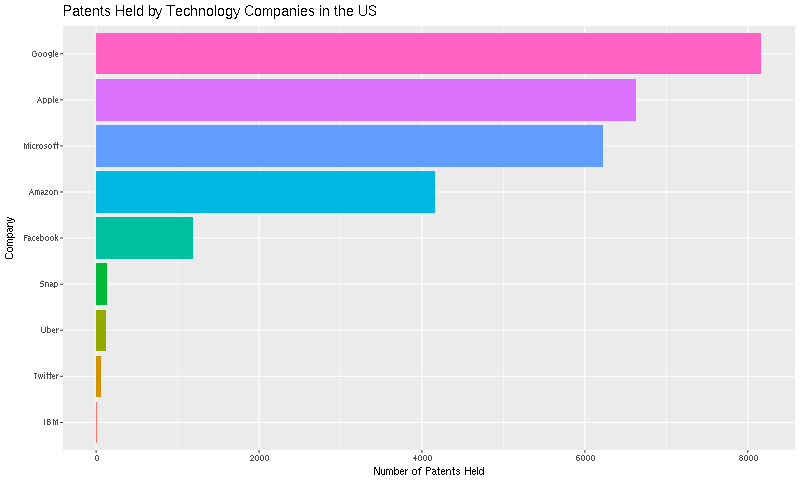

In [35]:
%%R -i df -w 800

library(ggplot2)
df$company <- factor(df$company, levels = df$company[order(df$patents)])
ggplot(df, aes(x=company, y=patents, fill=company)) + geom_bar(stat="identity") + coord_flip() +
    theme(legend.position="") + labs(y="Number of Patents Held", x="Company",
                                     title="Patents Held by Technology Companies in the US")

In [29]:
def randomly_sample_outdegrees_and_dates(link_list, num_samples):
    patent_outdegrees = []
    patent_dates = []
    for i in range(num_samples):
        try:
            # Constructs url with base path to get HTML from
            url = "http://patft.uspto.gov/" + link_list[i]
            f = urllib.request.urlopen(url)
            # Rate limiting sleep -- to avoid bot detection
            time.sleep(1)
            raw_html = f.read()
            
            # Gets Issued: date (if extant -- some patents have no record in the DB)
            date_regex = "((January|February|March|April|May|June|July|August|September|October|November|December) [0-9]{2}, [0-9]{4})"
            date = ""
            try:
                m = re.findall(date_regex, str(raw_html))
                if len(m) > 1:
                    date = [x[0] for x in m][1] # Second date corresponds to filing date, if it exists
                patent_dates.append(date)
            except Exception as e:
                print(e)
            
            doc = html.fromstring(raw_html)

            # Scrapes all outgoing patents links associated with the particular patent document for `url`
            outgoing_patents = doc.xpath("//table//a/@href")
            elements = [elt for elt in outgoing_patents]
            elements = [elt for elt in elements if "netacgi/nph-Parser" in elt]
            
            # ... and appends the number of these outgoing links to the patent_outdegrees list
            patent_outdegrees.append(len(elements))
        except Exception as e:
            print(e)
            
    return pd.DataFrame({"outdegree":patent_outdegrees, "date":patent_dates})
        
    
# Note: This totally works, but you can't turn up the scraping rate without being flagged as a bot by the site.
# So, despite the fact that it takes forever to run for a reasonable amount of articles, we just need to accept it...
# (Or learn to be patient)
amazon_od_df = randomly_sample_outdegrees_and_dates(amazon_patents, 100)
facebook_od_df = randomly_sample_outdegrees_and_dates(fb_patents, 100)
google_od_df = randomly_sample_outdegrees_and_dates(google_patents, 100)
apple_od_df = randomly_sample_outdegrees_and_dates(apple_patents, 100)
microsoft_od_df = randomly_sample_outdegrees_and_dates(microsoft_patents, 100)

In [30]:
amazon_average_outdeg = sum(amazon_od_df['outdegree']) / len(amazon_od_df['outdegree'])
google_average_outdeg = sum(google_od_df['outdegree']) / len(google_od_df['outdegree'])
facebook_average_outdeg = sum(facebook_od_df['outdegree']) / len(facebook_od_df['outdegree'])
apple_average_outdeg = sum(apple_od_df['outdegree']) / len(apple_od_df['outdegree'])
microsoft_average_outdeg = sum(microsoft_od_df['outdegree']) / len(microsoft_od_df['outdegree'])

bigFiveNames = ["Amazon", "Google", "Facebook", "Apple", "Microsoft"]
bigFiveOutdeg = [amazon_average_outdeg, google_average_outdeg, facebook_average_outdeg, apple_average_outdeg, microsoft_average_outdeg]
df2 = pd.DataFrame({"company": bigFiveNames, "patentoutdeg":bigFiveOutdeg})

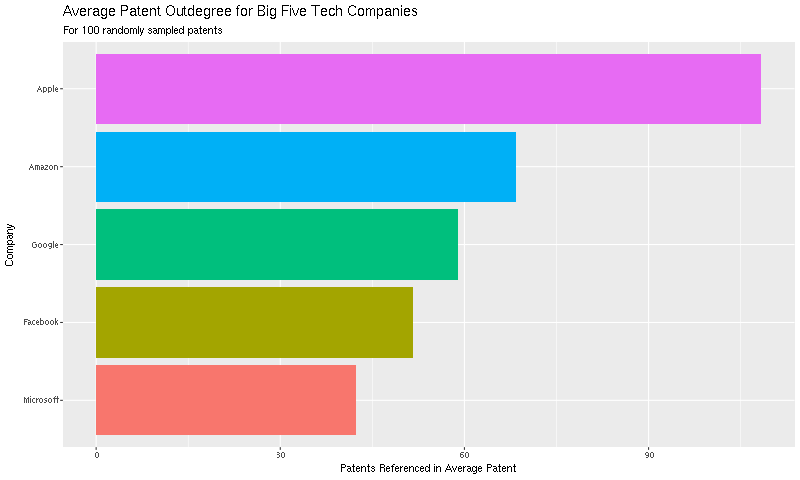

In [34]:
%%R -i df2 -w 800

library(ggplot2)
df2$company <- factor(df2$company, levels = df2$company[order(df2$patentoutdeg)])
ggplot(df2, aes(x=company, y=patentoutdeg, fill=company)) + geom_bar(stat="identity") + coord_flip() +
    theme(legend.position="") + labs(y="Patents Referenced in Average Patent", x="Company",
                                     title="Average Patent Outdegree for Big Five Tech Companies",
                                     subtitle="For 100 randomly sampled patents")

In [33]:
%%R

library(readr)
write_csv(df, "./tech_comp_num_patents.csv")
write_csv(df2, "./bigfive_patent_outdeg.csv")